In [1]:
import pandas as pd
import numpy as np
# allow multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("ad_clicks_100k_Treated.csv")
df.drop(columns="Unnamed: 0", inplace=True)

### Drop features that will not go into the model
- `id` (We do not need the variable ID as predictor, it does not make sense to use)
- `hour` (because hour was broken down into (day, weekday, hour_of_day)) 
- `day` (because we find that it will add no significant predictive value that makes sense in any future application, i.e. the dataset covers 10 days of the year and we have no way to know if any of those days is representative of the year, or if there was something exceptional happening. By using `hour_of_day` and `weekday` we average these values and thus make this possible effect less significant)   

In [3]:
pd.DataFrame(df.loc[df["click"] == 1, ['device_ip','click']]['device_ip'].value_counts()).head(10)
pd.DataFrame(df.loc[df["click"] == 1, ['device_id','click']]['device_id'].value_counts()).head(10)
# All id variables are weird


,device_ip
6b9769f2,106
431b3174,63
57cd4006,55
8a014cbb,44
9b1fe278,43
a8536f3a,41
75bb1b58,40
ceffea69,40
488a9a3e,39
b0070d9a,35


,device_id
a99f214a,14391
0f7c61dc,46
c357dbff,24
3cdb4052,8
afeffc18,6
936e92fb,3
73b81e30,3
21b3e725,2
b09da1c4,2
50856ea7,2


## Pre-processing:
- One Hot encoding for low cardinality features 
- Label encoding for medium cardinality features
- Mean encoding for high cardinality features

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

In [5]:
# Split into categorical type "O" and already encoded features
categorical_columns = [i for i in list(df.columns) if df[i].dtypes in ["O"] and i not in ['id','hour','day']]
encoded_categorical_columns = [i for i in list(df.columns) if df[i].dtypes not in ["O"] and i not in ['id','hour','day']]

In [6]:
data = df.copy()
one_hot = []
label_enc = []
mean_enc = []
for i in categorical_columns:
    if len(df[i].unique()) <= 15:
        # One hot encoding
        one_hot.append(i)
        data = pd.concat([data, pd.get_dummies(df[i], prefix='oneHot')],axis=1)
    elif 100 >= len(df[i].unique()) > 15:
        # Label encoding
        label_enc.append(i)
        label_encoder = []
        le = LabelEncoder()
        le.fit(data[i])    
        label_encoder.append(le)
        data[i] = le.transform(data[i])
    elif len(df[i].unique()) > 100:
        # Mean encoding
        mean_enc.append(i)
        mean_encoder = []
        le = LabelEncoder()
        le.fit(data[i])    
        mean_encoder.append(le)
        data[i] = le.transform(data[i])
        # mean_encoder_i = data.groupby([i])["click"].mean().to_dict()
        # data[i] = data[i].map(mean_encoder_i)

print('Previus Dataset Shape ->> ', df.shape)
print('Shape After Encoding  ->> ', data.shape, '\n')

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

Previus Dataset Shape ->>  (100000, 27)
Shape After Encoding  ->>  (100000, 34) 



## Split the Dataset

In [7]:
from sklearn.model_selection import train_test_split

# We drop weekday because we have replaced it with One Hot encoding of the feature
# X = data.drop(columns=['click','id','hour','weekday'])
X = data.drop(columns=['click','id','hour','weekday','device_ip','device_id','app_id'])
y = data['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(80000, 27)

(80000,)

(20000, 27)

(20000,)

# Modeling

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, plot_roc_curve
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

## Adjusting the dropped variables from X and taking them out of mean_enc also

In [9]:
mean_enc = ['site_id','site_domain', 'device_model']

In [10]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
    
def mean_encoded_cross_val(k, model, X, y, return_avg_pred=False, print_scores=True):
    """
    :parameter: k -> number of folds for cross validation
    :parameter: model -> (e.g: DecisionTreeClassifier())
    :parameter: X -> X_train from previous split
    :parameter: y -> y_train from previous split
    :parameter: return_avg_pred -> Return the original class and predicted class used to plot the average classification report
                returns a tuple (originalclass, predictedclass)

    """
    pd.options.mode.chained_assignment = None  # default='warn

    skf = StratifiedKFold(n_splits=k) #, random_state=42, shuffle=True)
    
    acc_acc_score = []
    acc_f1_score = []
    acc_roc_auc_score = []
    acc_precision_score = []
    
    # For Classification Report
    originalclass = []
    predictedclass = []
    
    for train_index , test_index in skf.split(X,y):
        X_train , X_test = X.loc[X.index.intersection(train_index)], X.loc[X.index.intersection(test_index)]
        y_train , y_test = y.loc[y.index.intersection(train_index)], y.loc[y.index.intersection(test_index)]

        # Mean Encoding within CV to avoid data leakage
        for i in mean_enc:
            data_train = pd.concat([X_train, y_train], axis=1)
            mean_encoder = data_train.groupby([i])["click"].mean()
            X_train[i] = X_train[i].map(mean_encoder)
            # Transform the test set based on the train
            X_test[i] = X_test[i].map(mean_encoder)
            # Fill nan values that may arise due to mapping with the global average
            X_test[i].fillna(mean_encoder.mean(), inplace = True)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Accumulate all folds
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)

        # Compute Scores
        acc = accuracy_score(y_pred , y_test)
        f1 = f1_score(y_pred, y_test)
        roc = roc_auc_score(y_pred, y_test)
        precision = precision_score(y_pred, y_test)

        acc_acc_score.append(acc)
        acc_f1_score.append(f1)
        acc_roc_auc_score.append(roc)
        acc_precision_score.append(precision)

    avg_acc_score = sum(acc_acc_score)/k
    avg_f1_score = sum(acc_f1_score)/k
    avg_roc_score = sum(acc_roc_auc_score)/k
    avg_precision_score = sum(acc_precision_score)/k

    scores = {'Accuracy':avg_acc_score, 'f1':avg_f1_score, 'ROC':avg_roc_score, 'Precision':avg_precision_score}

    if print_scores:
        print('accuracy of each fold - {}'.format(acc_acc_score))
        print('Avg accuracy : {}'.format(avg_acc_score))
        print('Avg f1 : {}'.format(avg_f1_score))
        print('Avg roc auc : {}'.format(avg_roc_score))
        print('Avg precision : {}'.format(avg_precision_score))
        print('\nAverage Classification Report for Cross-Validation\n', classification_report(originalclass, predictedclass)) 

    pd.options.mode.chained_assignment = 'warn'  # default='warn
    if return_avg_pred: 
        return originalclass, predictedclass, scores
    return scores

## "Manual" Grid Search with Mean Encoding Cross Validation

In [11]:
def param_grid_to_list(param_grid):
    return list(param_grid[0].values())

In [12]:
from itertools import product
from tqdm import tqdm
# Define Hyperparams to optimize
param_grid = [
    {'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_depth': [i for i in range(1,10,2)]}]
    
listOLists = param_grid_to_list(param_grid)    
# criterion, splitter, max_depth = ['gini','entropy'], ['best','random'], [i for i in range(1,10,2)]
# listOLists = [criterion, splitter, max_depth]
model = DecisionTreeClassifier(class_weight='balanced')
best_score = 0

for c, s, m in tqdm(product(*listOLists)):
    model = DecisionTreeClassifier(criterion=c, splitter=s, max_depth=m, class_weight='balanced')
    # Do Cross Validation with Mean encoding
    originalclass, predictedclass, scores = mean_encoded_cross_val(5, model, X_train, y_train, return_avg_pred=True, print_scores=False)

    # Get the best estimator
    if scores['f1'] >= best_score:
        best_model_dt = model
        best_model_dt_cv_scores = scores
        best_model_dt_originalclass = originalclass
        best_model_dt_predictedclass = predictedclass

print(best_model_dt)
print('Average CV Scores from Best Model Grid Search')
print(best_model_dt_cv_scores)

20it [00:17,  1.14it/s]

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, splitter='random')
Average CV Scores from Best Model Grid Search
{'Accuracy': 0.5992201061477234, 'f1': 0.3637397802201322, 'ROC': 0.5737250397274173, 'Precision': 0.6747270045878555}


In [13]:
originalclass, predictedclass, scores = mean_encoded_cross_val(5, best_model_dt, X_train, y_train, return_avg_pred=True)

accuracy of each fold - [0.7028253893715269, 0.6247077162899455, 0.5756197050517728, 0.649379051784738, 0.6143525741029641]
Avg accuracy : 0.6333768873201895
Avg f1 : 0.36873411945959084
Avg roc auc : 0.5782332335203714
Avg precision : 0.6297976720436088

Average Classification Report for Cross-Validation
               precision    recall  f1-score   support

           0       0.89      0.63      0.74     53125
           1       0.26      0.63      0.37     10853

    accuracy                           0.63     63978
   macro avg       0.58      0.63      0.56     63978
weighted avg       0.79      0.63      0.68     63978



# KNN Neighbors Classifier

As we understood KNN (K-Nearest Neighbor) is a simple supervised classification algorithm we can use to assign a class to new data point.  
Our data seems to be both unsupervised and supervised, but our target "clicks" is well defined. Hence, we decided to implement this model as well, in order to see if it performs better than the previous ones.

In [14]:
from itertools import product
# Define Hyperparams to optimize
# param_grid = [
#     {'classifier': [KNeighborsClassifier()], 
#     'preprocessing': [MinMaxScaler(), None],
#     'balancing': [RandomUnderSampler(replacement=False), RandomOverSampler(replacement=False), SMOTE(replacement=False)],
#     'classifier__n_neighbors': range(1, 10,2), 
#     'classifier__weights': ['uniform', 'distance']}]
    
preprocessing, balancing = [StandardScaler()], [RandomUnderSampler(), RandomOverSampler(), SMOTE()] 
# classifier__n_neighbors, classifier__weights = range(1, 10,2), ['uniform', 'distance']
classifier__n_neighbors, classifier__weights = [3, 5], ['distance']


listOLists = [preprocessing, balancing, classifier__n_neighbors, classifier__weights]
best_score = 0

for preprocessing, balancing, n_neighbors, weights in tqdm(product(*listOLists)):
    model = make_pipeline(preprocessing, balancing, KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights))
    # Do Cross Validation with Mean encoding
    originalclass, predictedclass, scores = mean_encoded_cross_val(5, model, X_train, y_train, return_avg_pred=True, print_scores=False)

    # Get the best estimator
    if scores['f1'] >= best_score:
        best_model_knn = model
        best_model_knn_cv_scores = scores
        best_model_knn_originalclass = originalclass
        best_model_knn_predictedclass = predictedclass

print(best_model_knn)
print('Average CV Scores from Best Model Grid Search')
print(best_model_knn_cv_scores)

6it [06:50, 68.42s/it]

Pipeline(steps=[('standardscaler', StandardScaler()), ('smote', SMOTE()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(weights='distance'))])
Average CV Scores from Best Model Grid Search
{'Accuracy': 0.692453330442305, 'f1': 0.32462046497917985, 'ROC': 0.5623624275448023, 'Precision': 0.4359266879333961}


## Getting CV Classification Report and a Confusion Matrix of all the Original vs Predicted Classes of the Cross Validation 

In [15]:
originalclass, predictedclass, scores = mean_encoded_cross_val(5, best_model_knn, X_train, y_train, return_avg_pred=True)

accuracy of each fold - [0.6885027784299914, 0.6964925954793453, 0.6876372764355193, 0.6931969069749278, 0.6939157566302652]
Avg accuracy : 0.6919490627900099
Avg f1 : 0.32399835946245686
Avg roc auc : 0.5619796095225016
Avg precision : 0.4353257068853399

Average Classification Report for Cross-Validation
               precision    recall  f1-score   support

           0       0.87      0.74      0.80     53125
           1       0.26      0.44      0.32     10853

    accuracy                           0.69     63978
   macro avg       0.56      0.59      0.56     63978
weighted avg       0.76      0.69      0.72     63978



Text(0.5, 1.0, 'Decision Tree Balanced Weights Dataset')

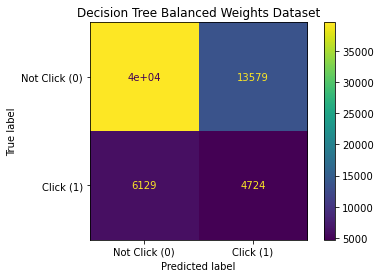

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
display_labels=['Not Click (0)','Click (1)']
cm = confusion_matrix(originalclass, predictedclass)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot() 
plt.title('Decision Tree Balanced Weights Dataset')

plt.show()

## CATBOOST

In [17]:
from catboost import CatBoostClassifier
from itertools import product
# Define Hyperparams to optimize
# param_grid= {'learning_rate': [0.1,0.05,0.03,0.01],
#         'depth': [3, 5, 7],
#         'eval_metric': f1_score?
#         'l2_leaf_reg': [1, 3, 5, 7, 9],
#         'loss_function': [None, 'F1'] }
    
learning_rate, depth = [0.1, 0.05, 0.03, 0.01], [3, 5, 7]#, [RandomUnderSampler(), RandomOverSampler(), SMOTE()] 
l2_leaf_reg, loss_function = [1, 3, 5, 7, 9], ['Logloss']

listOLists = [learning_rate, depth, l2_leaf_reg, loss_function]
best_score = 0

for learning_rate, depth, l2_leaf_reg, loss_function in tqdm(product(*listOLists)):
    model = make_pipeline(preprocessing, CatBoostClassifier(verbose=False, iterations=200, learning_rate=learning_rate, depth=depth, 
                            l2_leaf_reg=l2_leaf_reg, loss_function=loss_function, auto_class_weights='Balanced', early_stopping_rounds=20))
    # Do Cross Validation with Mean encoding
    originalclass, predictedclass, scores = mean_encoded_cross_val(5, model, X_train, y_train, return_avg_pred=True, print_scores=False)

    # Get the best estimator
    if scores['f1'] >= best_score:
        best_model_catb = model
        best_model_catb_cv_scores = scores
        best_model_catb_originalclass = originalclass
        best_model_catb_predictedclass = predictedclass

print(best_model_catb)
print('Average CV Scores from Best Model Grid Search')
print(best_model_catb_cv_scores)

60it [17:45, 17.76s/it]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x00000289808C0A00>)])
Average CV Scores from Best Model Grid Search
{'Accuracy': 0.6271142667062708, 'f1': 0.3765073447635536, 'ROC': 0.5815265072675936, 'Precision': 0.6638525293573383}


In [18]:
originalclass, predictedclass, scores = mean_encoded_cross_val(5, best_model_catb, X_train, y_train, return_avg_pred=True)

accuracy of each fold - [0.6264381310166706, 0.6325019485580671, 0.6215877000313774, 0.6269624306803093, 0.6280811232449298]
Avg accuracy : 0.6271142667062708
Avg f1 : 0.3765073447635536
Avg roc auc : 0.5815265072675936
Avg precision : 0.6638525293573383

Average Classification Report for Cross-Validation
               precision    recall  f1-score   support

           0       0.90      0.62      0.73     53125
           1       0.26      0.66      0.38     10853

    accuracy                           0.63     63978
   macro avg       0.58      0.64      0.56     63978
weighted avg       0.79      0.63      0.67     63978



## Choosing the Best Model (Work in progress)
- Metrics: `f1 score` and/or `roc_auc`

In [19]:
all_models = [best_model_knn, best_model_dt, best_model_catb]
best_score = 0
for model in tqdm(all_models):
    # Do Cross Validation with Mean encoding
    originalclass, predictedclass, scores = mean_encoded_cross_val(5, model, X_train, y_train, return_avg_pred=True, print_scores=False)

    # Get the best estimator
    if scores['f1'] >= best_score:
        best_model = model
        best_model_cv_scores = scores
        best_model_originalclass = originalclass
        best_model_predictedclass = predictedclass

print(best_model)
print('Average CV Scores from Best Model Grid Search')
print(best_model_cv_scores)

100%|██████████| 3/3 [04:02<00:00, 80.80s/it]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x00000289808C0A00>)])
Average CV Scores from Best Model Grid Search
{'Accuracy': 0.6271142667062708, 'f1': 0.3765073447635536, 'ROC': 0.5815265072675936, 'Precision': 0.6638525293573383}


In [20]:
originalclass, predictedclass, scores = mean_encoded_cross_val(5, best_model, X_train, y_train, return_avg_pred=True)

accuracy of each fold - [0.6264381310166706, 0.6325019485580671, 0.6215877000313774, 0.6269624306803093, 0.6280811232449298]
Avg accuracy : 0.6271142667062708
Avg f1 : 0.3765073447635536
Avg roc auc : 0.5815265072675936
Avg precision : 0.6638525293573383

Average Classification Report for Cross-Validation
               precision    recall  f1-score   support

           0       0.90      0.62      0.73     53125
           1       0.26      0.66      0.38     10853

    accuracy                           0.63     63978
   macro avg       0.58      0.64      0.56     63978
weighted avg       0.79      0.63      0.67     63978



# Choose Best Model 

In [21]:
# Mean encoding for train set
pd.options.mode.chained_assignment = None  # default='warn
for i in mean_enc:
    data_train = pd.concat([X_train, y_train], axis=1)
    mean_encoder = data_train.groupby([i])["click"].mean()
    X_train[i] = X_train[i].map(mean_encoder)
    # Transform the test set based on the train
    X_test[i] = X_test[i].map(mean_encoder)
    # Fill nan values that may arise due to mapping with the global average
    X_test[i].fillna(mean_encoder.mean(), inplace = True)
pd.options.mode.chained_assignment = 'warn'  # default='warn

print('------- Mean Encoding changes -------')
for i,v in enumerate(mean_enc):
    print(f'{v} now has {[len(X_train[i].unique()) for i in mean_enc][i]} categories vs {len(df[v].unique())} before')

------- Mean Encoding changes -------
site_id now has 186 categories vs 1461 before
site_domain now has 155 categories vs 1333 before
device_model now has 350 categories vs 3167 before


Text(0.5, 1.0, 'Best Model')

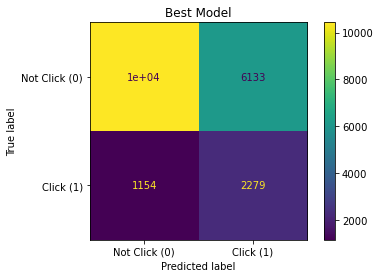

In [24]:
plot_confusion_matrix(best_model, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Best Model')
plt.show()

Text(0.5, 1.0, 'Best Model')

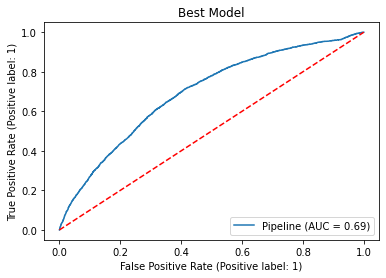

In [25]:
plot_roc_curve(best_model, X_test, y_test) 
plt.plot([0, 1], [0, 1],'r--')
plt.title('Best Model')

plt.show()

# Model Interpretation

# Other Experiments...

## Do more variable encoding for the remaining categories?

In [111]:
for i,v in enumerate(encoded_categorical_columns):
    print(f'{v} has {[len(data[i].unique()) for i in encoded_categorical_columns][i]} unique categories')

click has 2 unique categories
C1 has 7 unique categories
banner_pos has 7 unique categories
device_type has 4 unique categories
device_conn_type has 4 unique categories
C14 has 1713 unique categories
C15 has 8 unique categories
C16 has 9 unique categories
C17 has 399 unique categories
C18 has 4 unique categories
C19 has 65 unique categories
C20 has 157 unique categories
C21 has 59 unique categories
hour_of_day has 24 unique categories


# Cost Sensitive Learning vs Random Under Sampling

In [15]:
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

pipe_1 = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight='balanced'))
# pipe_2 = make_pipeline(StandardScaler(), RandomUnderSampler(replacement=False), DecisionTreeClassifier())
pipe_2 = make_pipeline(StandardScaler(), SMOTE(), KNeighborsClassifier(n_neighbors=3))


In [16]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

from sklearn.model_selection import cross_validate
scores1 = cross_validate(pipe_1,
                        X_train, y_train, cv=10, return_estimator=True,
                        scoring=make_scorer(classification_report_with_accuracy_score))
                        # scoring=('roc_auc', 'recall','precision'))
print('PIPE 1')
print(classification_report(originalclass, predictedclass)) 

scores2 = cross_validate(pipe_2,
                        X_train, y_train, cv=10, return_estimator=True,
                        scoring=make_scorer(classification_report_with_accuracy_score))
print('PIPE 2')

# Average values in classification report for all folds in a K-fold Cross-validation  
print(classification_report(originalclass, predictedclass)) 

PIPE 1
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     66402
           1       0.26      0.26      0.26     13598

    accuracy                           0.75     80000
   macro avg       0.55      0.55      0.55     80000
weighted avg       0.75      0.75      0.75     80000

PIPE 2
              precision    recall  f1-score   support

           0       0.85      0.78      0.81    132804
           1       0.25      0.35      0.29     27196

    accuracy                           0.71    160000
   macro avg       0.55      0.57      0.55    160000
weighted avg       0.75      0.71      0.73    160000



In [19]:
pipe_1.fit(X_train, y_train)
pipe_2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()), ('smote', SMOTE()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

Text(0.5, 1.0, 'Decision Tree Balanced Weights Dataset')

Text(0.5, 1.0, 'KNN SMOTE')

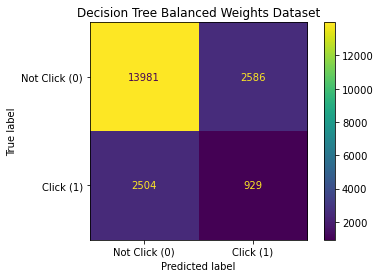

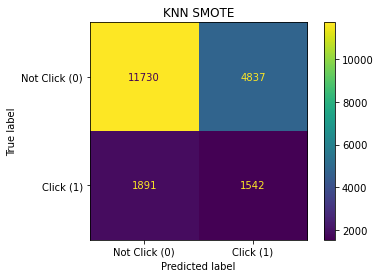

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(pipe_1, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Decision Tree Balanced Weights Dataset')

plot_confusion_matrix(pipe_2, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
# plt.title('Decision Tree Undersampling Majority Class')
plt.title('KNN SMOTE')

plt.show()